In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm #progress bar
import rdkit
from rdkit import Chem #Chemistry
from rdkit.Chem import rdMolDescriptors #molecular descriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
rdkit.__version__

import xgboost as xgb
import sklearn
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import fbeta_score, make_scorer
from xgboost.sklearn import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split #ML training
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error #ML stats
from tdc.single_pred import ADME
from tdc.benchmark_group import admet_group

from tdc import BenchmarkGroup
import warnings
warnings.filterwarnings("ignore")

In [124]:
group = admet_group(path = 'data/')

pred_valid_list_xgb = []
pred_valid_list_rf = []
pred_valid_list_svm = []
pred_valid_list_adb = []
pred_valid_list_cnn = []
        
pred_test_list_xgb = []
pred_test_list_rf = []
pred_test_list_svm = []
pred_test_list_adb = []
pred_test_list_cnn = []

best_params_list_xgb = []
best_params_list_svm = []

for seed in [1, 2, 3, 4, 5]:
    pred_valid_xgb = {}
    pred_valid_rf = {}
    pred_valid_svm = {}
    pred_valid_adb = {}
    pred_valid_cnn = {}

    pred_test_xgb = {}
    pred_test_rf = {}
    pred_test_svm = {}
    pred_test_adb = {}
    pred_test_cnn = {}

    benchmark = group.get('Caco2_Wang')
    name = benchmark['name']
    train_val, test = benchmark['train_val'], benchmark['test']
    train, valid = group.get_train_valid_split(benchmark = name, split_type = 'default', seed = seed)

    PandasTools.AddMoleculeColumnToFrame(train, smilesCol='Drug')
    radius=2
    nBits=1024
    ECFP6 = [AllChem.GetMorganFingerprintAsBitVect(x,radius=radius, nBits=nBits) for x in train['ROMol']]
    ecfp6_name = [f'Bit_{i}' for i in range(nBits)]
    ecfp6_bits = [list(l) for l in ECFP6]
    Y = train['Y']
    train = pd.DataFrame(ecfp6_bits, index = train.Drug, columns=ecfp6_name).reset_index(drop = False)
    train['Y'] = Y

    PandasTools.AddMoleculeColumnToFrame(valid, smilesCol='Drug')
    radius=2
    nBits=1024
    ECFP6 = [AllChem.GetMorganFingerprintAsBitVect(x,radius=radius, nBits=nBits) for x in valid['ROMol']]
    ecfp6_name = [f'Bit_{i}' for i in range(nBits)]
    ecfp6_bits = [list(l) for l in ECFP6]
    Y = valid['Y']
    valid = pd.DataFrame(ecfp6_bits, index = valid.Drug, columns=ecfp6_name).reset_index(drop = False)
    valid['Y'] = Y

    PandasTools.AddMoleculeColumnToFrame(benchmark['test'], smilesCol='Drug')
    radius=2
    nBits=1024
    ECFP6 = [AllChem.GetMorganFingerprintAsBitVect(x,radius=radius, nBits=nBits) for x in benchmark['test']['ROMol']]
    ecfp6_name = [f'Bit_{i}' for i in range(nBits)]
    ecfp6_bits = [list(l) for l in ECFP6]
    Y = benchmark['test']['Y']
    benchmark['test'] = pd.DataFrame(ecfp6_bits, index = benchmark['test'].Drug, columns=ecfp6_name).reset_index(drop = False)
    benchmark['test']['Y'] = Y

    train_X = train.drop(columns = ["Drug","Y"])
    train_y = train.Y
    valid_X = valid.drop(columns = ["Drug","Y"])
    globals()['valid_y_%s'%seed] = valid.Y
    test_X = benchmark['test'].drop(columns = ["Drug","Y"])
    test_y = benchmark['test'].Y

    
    #XGBoost + Morgan
    xgb_parameters = {'objective':['reg:squarederror'],
            'booster':['gbtree','gblinear'],
            'learning_rate': [0.1],
            'max_depth': [7,10,15,20],
            'min_child_weight': [10,15,20,25],
            'colsample_bytree': [0.8, 0.9, 1],
            'n_estimators': [300,400,500,600],
            "reg_alpha"   : [0.5,0.2,1],
            "reg_lambda"  : [2,3,5],
            "gamma"       : [1,2,3]}

    xgb_model = XGBRegressor()
    grid_obj_xgb = RandomizedSearchCV(xgb_model, xgb_parameters, cv=5, n_iter=15, scoring='neg_mean_absolute_error', verbose=5, n_jobs=1)
    grid_obj_xgb.fit(train_X, train_y, verbose = 1)
    y_pred_valid_xgb = grid_obj_xgb.predict(valid_X)
    y_pred_test_xgb = grid_obj_xgb.predict(test_X)
    pred_valid_xgb[name] = y_pred_valid_xgb
    pred_valid_list_xgb.append(pred_valid_xgb)
    pred_test_xgb[name] = y_pred_test_xgb
    pred_test_list_xgb.append(pred_test_xgb)
    bp_xgb = grid_obj_xgb.best_params_
    best_params_list_xgb.append(bp_xgb)

    #Random Forest + Morgan
    rf_model = RandomForestRegressor()
    rf_model.fit(train_X, train_y)
    y_pred_valid_rf = rf_model.predict(valid_X)
    y_pred_test_rf = rf_model.predict(test_X)
    pred_valid_rf[name] = y_pred_valid_rf
    pred_valid_list_rf.append(pred_valid_rf)
    pred_test_rf[name] = y_pred_test_rf
    pred_test_list_rf.append(pred_test_rf)

    #SVM + Morgan
    svm_parameters = {
        'C': [0.1, 1, 10, 100, 1000],
        'epsilon': [0.0001, 0.001, 0.01, 0.1, 0.5],
        'gamma': [0.0001, 0.001, 0.01, 0.1, 1]
    }
    svm_model = SVR(kernel="rbf")
    grid_obj_svm = RandomizedSearchCV(svm_model, svm_parameters, cv=5, n_iter=15, scoring='neg_mean_absolute_error', verbose=5, n_jobs=1)
    grid_obj_svm.fit(train_X, train_y)
    y_pred_valid_svm = grid_obj_svm.predict(valid_X)
    y_pred_test_svm = grid_obj_svm.predict(test_X)
    pred_valid_svm[name] = y_pred_valid_svm
    pred_valid_list_svm.append(pred_valid_svm)
    pred_test_svm[name] = y_pred_test_svm
    pred_test_list_svm.append(pred_test_svm)
    bp_svm = grid_obj_svm.best_params_
    best_params_list_svm.append(bp_svm)
    
    #AdaBoost + Morgan
    DTR = DecisionTreeRegressor(max_depth=4)
    adb_model = AdaBoostRegressor(n_estimators=300, base_estimator=DTR, learning_rate=1)
    adb_model.fit(train_X, train_y)
    y_pred_valid_adb = adb_model.predict(valid_X)
    y_pred_test_adb = adb_model.predict(test_X)
    pred_valid_adb[name] = y_pred_valid_adb
    pred_valid_list_adb.append(pred_valid_adb)
    pred_test_adb[name] = y_pred_test_adb
    pred_test_list_adb.append(pred_test_adb)

    '''
    #for GCN, refer to https://github.com/kexinhuang12345/DeepPurpose
    #GCN
    drug_encoding = 'DGL_GCN'
    benchmark = group.get('Half_Life_Obach')
    train_gcn, valid_gcn = group.get_train_valid_split(benchmark = benchmark['name'], split_type = 'default', seed = seed)
    train_gcn = data_process(X_drug = train_gcn.Drug.values, y = train_gcn.Y.values, drug_encoding = drug_encoding, split_method='no_split')
    val_gcn = data_process(X_drug = valid_gcn.Drug.values, y = valid_gcn.Y.values, drug_encoding = drug_encoding, split_method='no_split')
    test_gcn = data_process(X_drug = benchmark['test'].Drug.values, y = benchmark['test'].Y.values, drug_encoding = drug_encoding, split_method='no_split')
    config = generate_config(drug_encoding = drug_encoding,
                            cls_hidden_dims = [512],
                            train_epoch = 10,
                            LR = 0.001,
                            batch_size = 128,
                            )

    gcn_model = models.model_initialize(**config)
    gcn_model.train(train_gcn, val_gcn, test_gcn, verbose = True)
    y_pred_test_gcn = gcn_model.predict(test_gcn)
    predictions_gcn[name] = y_pred_test_gcn
    predictions_list_gcn.append(predictions_gcn)
    '''

    #CNN + Morgan
    train_X_cnn = train_X.to_numpy()
    valid_X_cnn = valid_X.to_numpy()
    test_X_cnn = test_X.to_numpy()
    train_X_cnn = train_X_cnn.reshape(train_X_cnn.shape[0], train_X_cnn.shape[1], 1)
    valid_X_cnn = valid_X_cnn.reshape(valid_X_cnn.shape[0], valid_X_cnn.shape[1], 1)
    test_X_cnn = test_X_cnn.reshape(test_X_cnn.shape[0], test_X_cnn.shape[1], 1)
    cnn_model = Sequential()
    cnn_model.add(Conv1D(32, 2, activation="relu", input_shape=(1024,1)))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(64, activation="relu"))
    cnn_model.add(Dense(1))
    cnn_model.compile(loss="mse", optimizer="adam")
    cnn_model.fit(train_X_cnn, train_y, batch_size=12, epochs=10, verbose=0)
    y_pred_valid_cnn = cnn_model.predict(valid_X_cnn)
    y_pred_test_cnn = cnn_model.predict(test_X_cnn)
    y_pred_valid_cnn_copy = []
    for i in range(len(y_pred_valid_cnn)):
        y_pred_valid_cnn_copy.append(y_pred_valid_cnn[i][0])
    y_pred_test_cnn_copy = []
    for i in range(len(y_pred_test_cnn)):
        y_pred_test_cnn_copy.append(y_pred_test_cnn[i][0])
    pred_valid_cnn[name] = np.array(y_pred_valid_cnn_copy)
    pred_valid_list_cnn.append(pred_valid_cnn)
    pred_test_cnn[name] = np.array(y_pred_test_cnn_copy)
    pred_test_list_cnn.append(pred_test_cnn)


xgb_perform = group.evaluate_many(pred_test_list_xgb)
rf_perform = group.evaluate_many(pred_test_list_rf)
svm_perform = group.evaluate_many(pred_test_list_svm)
adb_perform = group.evaluate_many(pred_test_list_adb)
cnn_perform = group.evaluate_many(pred_test_list_cnn)

Found local copy...
generating training, validation splits...
100%|██████████| 728/728 [00:00<00:00, 2022.64it/s]


Fitting 5 folds for each of 15 candidates, totalling 75 fits
[03:20:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[CV 1/5] END booster=gblinear, colsample_bytree=0.8, gamma=3, learning_rate=0.1, max_depth=10, min_child_weight=15, n_estimators=300, objective=reg:squarederror, reg_alpha=1, reg_lambda=2;, score=-0.580 total time=   0.8s
[03:20:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[CV 2/5] END booster=gblinear, colsample_bytree=0.8, gamma=3, learning_rate=0.1, max_depth=10, min_child_weight=15, n_estimators=300, objective=reg:squarederror, reg_alpha=1, reg_lambda=2;, score=-0.683 total time=   0.8s
[03:20:22] WARNING: /Users/runn

generating training, validation splits...
100%|██████████| 728/728 [00:00<00:00, 2069.74it/s]


Fitting 5 folds for each of 15 candidates, totalling 75 fits
[03:24:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[CV 1/5] END booster=gblinear, colsample_bytree=0.9, gamma=3, learning_rate=0.1, max_depth=20, min_child_weight=25, n_estimators=600, objective=reg:squarederror, reg_alpha=1, reg_lambda=5;, score=-0.663 total time=   1.5s
[03:24:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[CV 2/5] END booster=gblinear, colsample_bytree=0.9, gamma=3, learning_rate=0.1, max_depth=20, min_child_weight=25, n_estimators=600, objective=reg:squarederror, reg_alpha=1, reg_lambda=5;, score=-0.604 total time=   1.5s
[03:24:15] WARNING: /Users/runn

generating training, validation splits...
100%|██████████| 728/728 [00:00<00:00, 2012.49it/s]


Fitting 5 folds for each of 15 candidates, totalling 75 fits
[03:27:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[CV 1/5] END booster=gblinear, colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=20, n_estimators=300, objective=reg:squarederror, reg_alpha=0.5, reg_lambda=2;, score=-0.678 total time=   0.8s
[03:27:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[CV 2/5] END booster=gblinear, colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=7, min_child_weight=20, n_estimators=300, objective=reg:squarederror, reg_alpha=0.5, reg_lambda=2;, score=-0.660 total time=   0.7s
[03:27:12] WARNING: /Users/ru

generating training, validation splits...
100%|██████████| 728/728 [00:00<00:00, 2029.70it/s]


Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END booster=gbtree, colsample_bytree=1, gamma=2, learning_rate=0.1, max_depth=20, min_child_weight=20, n_estimators=600, objective=reg:squarederror, reg_alpha=0.5, reg_lambda=5;, score=-0.574 total time=   4.7s
[CV 2/5] END booster=gbtree, colsample_bytree=1, gamma=2, learning_rate=0.1, max_depth=20, min_child_weight=20, n_estimators=600, objective=reg:squarederror, reg_alpha=0.5, reg_lambda=5;, score=-0.566 total time=   5.3s
[CV 3/5] END booster=gbtree, colsample_bytree=1, gamma=2, learning_rate=0.1, max_depth=20, min_child_weight=20, n_estimators=600, objective=reg:squarederror, reg_alpha=0.5, reg_lambda=5;, score=-0.479 total time=   6.7s
[CV 4/5] END booster=gbtree, colsample_bytree=1, gamma=2, learning_rate=0.1, max_depth=20, min_child_weight=20, n_estimators=600, objective=reg:squarederror, reg_alpha=0.5, reg_lambda=5;, score=-0.536 total time=   5.9s
[CV 5/5] END booster=gbtree, colsample_bytree=1, gamma=2, l

generating training, validation splits...
100%|██████████| 728/728 [00:00<00:00, 1901.73it/s]


Fitting 5 folds for each of 15 candidates, totalling 75 fits
[03:36:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[CV 1/5] END booster=gblinear, colsample_bytree=0.9, gamma=3, learning_rate=0.1, max_depth=15, min_child_weight=15, n_estimators=400, objective=reg:squarederror, reg_alpha=0.2, reg_lambda=5;, score=-0.716 total time=   1.7s
[03:36:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[CV 2/5] END booster=gblinear, colsample_bytree=0.9, gamma=3, learning_rate=0.1, max_depth=15, min_child_weight=15, n_estimators=400, objective=reg:squarederror, reg_alpha=0.2, reg_lambda=5;, score=-0.592 total time=   1.5s
[03:36:49] WARNING: /Users/

In [125]:
print("xgb_perform:", xgb_perform, "\n rf_perform:", rf_perform, "\n svm_perform:", svm_perform, "\n adb_perform:", adb_perform, "\n cnn_perform:", cnn_perform)

xgb_perform: {'caco2_wang': [0.512, 0.02]} 
 rf_perform: {'caco2_wang': [0.454, 0.018]} 
 svm_perform: {'caco2_wang': [0.418, 0.028]} 
 adb_perform: {'caco2_wang': [0.49, 0.015]} 
 cnn_perform: {'caco2_wang': [0.716, 0.078]}


In [126]:
y_test = benchmark['test'].Y
y_test = np.array(y_test)


In [127]:
def rank_object(array): # convert scores into ranks
    arg_a = np.argsort(array)
    b = np.flip(np.arange(len(arg_a)))
    a = np.zeros_like(arg_a)
    for i in range(len(arg_a)):
        a[arg_a[i]] = b[i]
    return a

In [128]:
def score_to_rank(array):
  res = np.argsort(np.flip(np.argsort(array)))+1
  return res

In [129]:
def normalize(array): # define function for normalization of scores
    maximum = np.max(array)
    minimum = np.min(array)
    norm_list = []
    for i in range(len(array)):
        norm_list.append((array[i]-minimum)/(maximum-minimum))
    return np.array(norm_list)

In [130]:
predictions_valid_xgb = []
predictions_valid_rf = []
predictions_valid_svm = []
predictions_valid_adb = []
predictions_valid_cnn = []

predictions_test_xgb = []
predictions_test_rf = []
predictions_test_svm = []
predictions_test_adb = []
predictions_test_cnn = []

scoreSys = ['xgb', 'rf', 'svm', 'adb', 'cnn']

for sys in scoreSys:
  for seed in range(len(globals()['pred_valid_list_%s' % sys])):
    globals()['predictions_valid_%s' % sys].append(list(globals()['pred_valid_list_%s' % sys][seed].values())[0])

for sys in scoreSys:
  for seed in range(len(globals()['pred_test_list_%s' % sys])):
    globals()['predictions_test_%s' % sys].append(list(globals()['pred_test_list_%s' % sys][seed].values())[0])

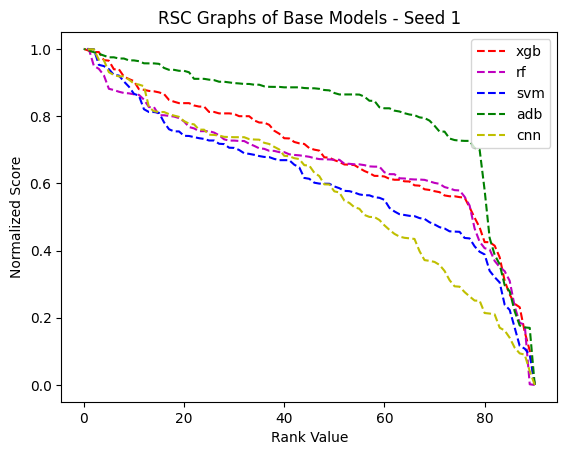

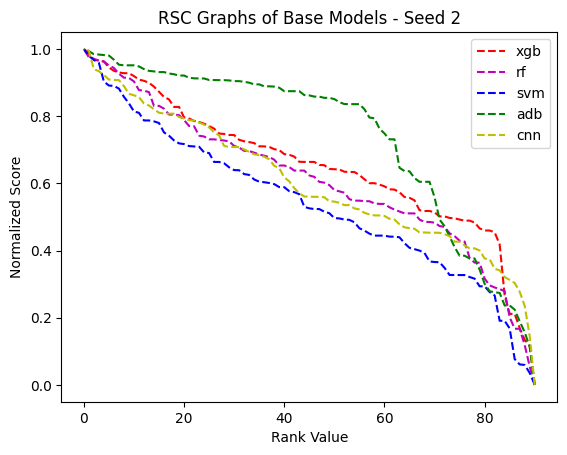

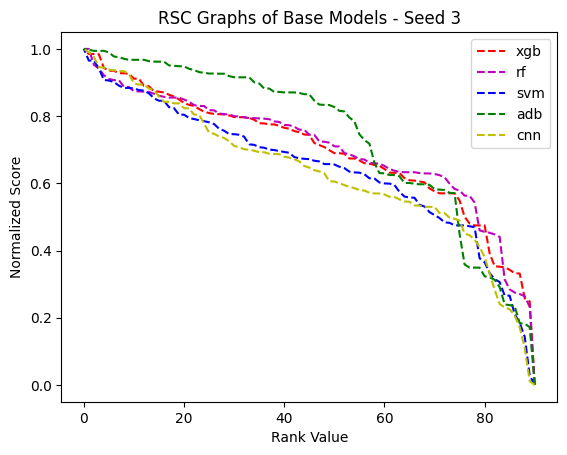

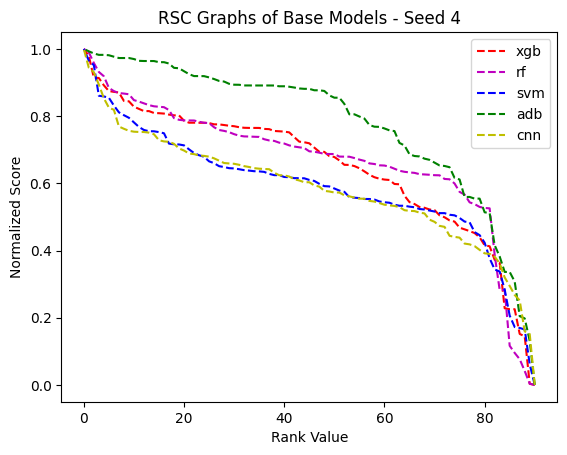

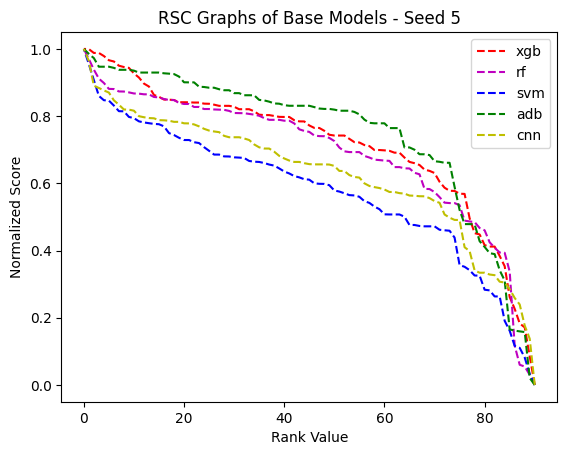

In [131]:
# RSC graphs
colors = ['r--', 'm--', 'b--', 'g--', 'y--']

for seed in range(len(globals()['predictions_valid_%s' % sys])):
  fig, ax = plt.subplots()
  ranks = np.flip(np.arange(len(predictions_valid_xgb[seed])))
  for z in range(len(scoreSys)):
    globals()['line%s' % (z+1)] = plt.plot(ranks, np.sort(normalize(globals()['predictions_valid_%s' % scoreSys[z]][seed])), colors[z], label = scoreSys[z])
    plt.legend(loc = 'upper right')
    plt.title('RSC Graphs of Base Models - Seed %s' % str(seed+1))
    plt.xlabel('Rank Value')
    plt.ylabel('Normalized Score')
  plt.show()
  image_name = benchmark['name'] + '_morgan_rsc_seed_%s'% str(seed+1) + '.png'
  image_format = 'png'
  fig.savefig(image_name, format=image_format, dpi=1200)


In [132]:
ds_score = [[] for _ in range(5)]
for sys in scoreSys:
  for seed in range(len(ds_score)):
    loc = scoreSys.index(sys)
    scoreSys.remove(sys)
    ds = 0
    for i in range(len(scoreSys)):
      ds += np.sum(np.square(normalize(np.sort(globals()['predictions_valid_%s' % sys][seed]))-normalize(np.sort(globals()['predictions_valid_%s' % scoreSys[i]][seed]))))
    ds = ds/len(scoreSys)
    scoreSys.insert(loc, sys)
    ds_score[seed].append(ds)

In [133]:
ds_score

[[1.0197121003547207,
  1.112083779564193,
  1.4384818141152802,
  3.622568832334246,
  2.330688802861289],
 [0.9222806399078096,
  0.8267861145915476,
  1.759277720929667,
  2.908733938239863,
  1.0327188410955521],
 [0.4261178569542713,
  0.515297184062824,
  0.5672927935853574,
  1.1436288058840889,
  0.7287125088853981],
 [0.7802398835892836,
  0.8790957513908411,
  1.2868301402597373,
  2.693151614451184,
  1.4336921313188604],
 [0.7812271438289432,
  0.6528983902461707,
  1.6558248081738762,
  1.3738819705713972,
  0.8458018356348039]]

In [134]:
ds_rank = np.reciprocal(ds_score)

In [135]:
ds_rank

array([[0.98066896, 0.89921283, 0.69517737, 0.2760472 , 0.42905771],
       [1.08426867, 1.20950265, 0.56841509, 0.34379219, 0.96831776],
       [2.34676858, 1.94062772, 1.76275816, 0.87440959, 1.37228329],
       [1.28165712, 1.13753251, 0.77710334, 0.37131218, 0.69749982],
       [1.28003745, 1.5316319 , 0.60392863, 0.72786456, 1.18231004]])

In [136]:
def mean_absolute_error(y_pred, y_true):
  res = np.mean(np.abs(y_pred - y_true))
  return res

In [137]:
ps_score = [[] for _ in range(5)]

In [138]:
def spearman_corr(y_pred_rank, y_true_rank):
  n = len(y_pred_rank)
  res = 1 - 6 * np.sum((y_pred_rank - y_true_rank)**2) / (n*(n**2-1))
  return res

In [139]:
for sys in scoreSys:
  for seed in range(len(ps_score)):
    ps = mean_absolute_error(globals()['predictions_valid_%s' % sys][seed], globals()['valid_y_%s'%str(seed+1)])
    ps_score[seed].append(ps)

In [140]:
ps_score

[[0.3852555797111093,
  0.44672219801666696,
  0.3655723251244669,
  0.47161707234795724,
  0.5132748027150582],
 [0.47996699000948406,
  0.46316338154467573,
  0.44516790676094903,
  0.49607239172700823,
  0.5723856862008566],
 [0.4142120248381562,
  0.40717785568772896,
  0.44556596966446943,
  0.43296027914522833,
  0.6001056426830921],
 [0.4713206489138424,
  0.42335560893738927,
  0.4489978643190553,
  0.48672238824854014,
  0.495193952001081],
 [0.48900847622170923,
  0.4769450040083024,
  0.449210940184263,
  0.48058191005693857,
  0.470559269186066]]

In [141]:
def powerset(s):
    x = len(s)
    ls = []
    for i in range(1 << x):
        ls.append([s[j] for j in range(x) if (i & (1 << j))])
    return ls[1:]

models = powerset(scoreSys)

def myFunc(e):
  return len(e)

models.sort(key=myFunc)

models_list = []
for i in range(len(models)):
  if len(models[i]) == 1:
    models_list.append(models[i][0])
  elif len(models[i]) == 2:
    models_list.append(models[i][0]+'&'+models[i][1])
  elif len(models[i]) == 3:
    models_list.append(models[i][0]+'&'+models[i][1]+'&'+models[i][2])
  elif len(models[i]) == 4:
    models_list.append(models[i][0]+'&'+models[i][1]+'&'+models[i][2]+'&'+models[i][3])
  elif len(models[i]) == 5:
    models_list.append(models[i][0]+'&'+models[i][1]+'&'+models[i][2]+'&'+models[i][3]+'&'+models[i][4])

# Perform average score combinations

In [142]:
avg_score_combine_seed1 = pd.DataFrame({'xgb':predictions_test_xgb[0], 'rf':predictions_test_rf[0], 'svm':predictions_test_svm[0], 'adb':predictions_test_adb[0], 'cnn':predictions_test_cnn[0]})
avg_score_combine_seed2 = pd.DataFrame({'xgb':predictions_test_xgb[1], 'rf':predictions_test_rf[1], 'svm':predictions_test_svm[1], 'adb':predictions_test_adb[1], 'cnn':predictions_test_cnn[1]})
avg_score_combine_seed3 = pd.DataFrame({'xgb':predictions_test_xgb[2], 'rf':predictions_test_rf[2], 'svm':predictions_test_svm[2], 'adb':predictions_test_adb[2], 'cnn':predictions_test_cnn[2]})
avg_score_combine_seed4 = pd.DataFrame({'xgb':predictions_test_xgb[3], 'rf':predictions_test_rf[3], 'svm':predictions_test_svm[3], 'adb':predictions_test_adb[3], 'cnn':predictions_test_cnn[3]})
avg_score_combine_seed5 = pd.DataFrame({'xgb':predictions_test_xgb[4], 'rf':predictions_test_rf[4], 'svm':predictions_test_svm[4], 'adb':predictions_test_adb[4], 'cnn':predictions_test_cnn[4]})

In [143]:
def avg_score_combine(models_list, single_score):
  for j in models_list[len(scoreSys):]:
    if len(j.split('&')) == 2:
      single_score[j] = (single_score[j.split('&')[0]]+single_score[j.split('&')[1]]) / 2
    elif len(j.split('&')) == 3:
      single_score[j] = (single_score[j.split('&')[0]]+single_score[j.split('&')[1]]+single_score[j.split('&')[2]]) / 3
    elif len(j.split('&')) == 4:
      single_score[j] = (single_score[j.split('&')[0]]+single_score[j.split('&')[1]]+single_score[j.split('&')[2]]+single_score[j.split('&')[3]]) / 4
    elif len(j.split('&')) == 5:
      single_score[j] = (single_score[j.split('&')[0]]+single_score[j.split('&')[1]]+single_score[j.split('&')[2]]+single_score[j.split('&')[3]]+single_score[j.split('&')[4]]) / 5

In [144]:
avg_score_combine(models_list, avg_score_combine_seed1)
avg_score_combine(models_list, avg_score_combine_seed2)
avg_score_combine(models_list, avg_score_combine_seed3)
avg_score_combine(models_list, avg_score_combine_seed4)
avg_score_combine(models_list, avg_score_combine_seed5)

# Perform average rank combinations

In [145]:
def score_to_rank(array):
  res = np.argsort(np.flip(np.argsort(array)))+1
  return res

In [146]:
avg_rank_combine_seed1 = pd.DataFrame({'xgb':score_to_rank(predictions_test_xgb[0]), 'rf':score_to_rank(predictions_test_rf[0]), 'svm':score_to_rank(predictions_test_svm[0]), 'adb':score_to_rank(predictions_test_adb[0]), 'cnn':score_to_rank(predictions_test_cnn[0])})
avg_rank_combine_seed2 = pd.DataFrame({'xgb':score_to_rank(predictions_test_xgb[1]), 'rf':score_to_rank(predictions_test_rf[1]), 'svm':score_to_rank(predictions_test_svm[1]), 'adb':score_to_rank(predictions_test_adb[1]), 'cnn':score_to_rank(predictions_test_cnn[1])})
avg_rank_combine_seed3 = pd.DataFrame({'xgb':score_to_rank(predictions_test_xgb[2]), 'rf':score_to_rank(predictions_test_rf[2]), 'svm':score_to_rank(predictions_test_svm[2]), 'adb':score_to_rank(predictions_test_adb[2]), 'cnn':score_to_rank(predictions_test_cnn[2])})
avg_rank_combine_seed4 = pd.DataFrame({'xgb':score_to_rank(predictions_test_xgb[3]), 'rf':score_to_rank(predictions_test_rf[3]), 'svm':score_to_rank(predictions_test_svm[3]), 'adb':score_to_rank(predictions_test_adb[3]), 'cnn':score_to_rank(predictions_test_cnn[3])})
avg_rank_combine_seed5 = pd.DataFrame({'xgb':score_to_rank(predictions_test_xgb[4]), 'rf':score_to_rank(predictions_test_rf[4]), 'svm':score_to_rank(predictions_test_svm[4]), 'adb':score_to_rank(predictions_test_adb[4]), 'cnn':score_to_rank(predictions_test_cnn[4])})

In [147]:
def avg_rank_combine(models_list, single_rank):
  for j in models_list[len(scoreSys):]:
    if len(j.split('&')) == 2:
      single_rank[j+'_r'] = (single_rank[j.split('&')[0]]+single_rank[j.split('&')[1]]) / 2
    elif len(j.split('&')) == 3:
      single_rank[j+'_r'] = (single_rank[j.split('&')[0]]+single_rank[j.split('&')[1]]+single_rank[j.split('&')[2]]) / 3
    elif len(j.split('&')) == 4:
      single_rank[j+'_r'] = (single_rank[j.split('&')[0]]+single_rank[j.split('&')[1]]+single_rank[j.split('&')[2]]+single_rank[j.split('&')[3]]) / 4
    elif len(j.split('&')) == 5:
      single_rank[j+'_r'] = (single_rank[j.split('&')[0]]+single_rank[j.split('&')[1]]+single_rank[j.split('&')[2]]+single_rank[j.split('&')[3]]+single_rank[j.split('&')[4]]) / 5

In [148]:
avg_rank_combine(models_list, avg_rank_combine_seed1)
avg_rank_combine(models_list, avg_rank_combine_seed2)
avg_rank_combine(models_list, avg_rank_combine_seed3)
avg_rank_combine(models_list, avg_rank_combine_seed4)
avg_rank_combine(models_list, avg_rank_combine_seed5)

# Perform weighted score combination by diversity strength

In [149]:
ds_score_combine_seed1 = pd.DataFrame()
ds_score_combine_seed2 = pd.DataFrame()
ds_score_combine_seed3 = pd.DataFrame()
ds_score_combine_seed4 = pd.DataFrame()
ds_score_combine_seed5 = pd.DataFrame()

In [150]:
def ds_score_combine(models_list, single_score, ds_score_combine, ds_score):
  for j in models_list[len(scoreSys):]:
    if len(j.split('&')) == 2:
      ds_score_combine[j+'_ds'] = (single_score[j.split('&')[0]]*ds_score[scoreSys.index(j.split('&')[0])]+single_score[j.split('&')[1]]*ds_score[scoreSys.index(j.split('&')[1])])/(ds_score[scoreSys.index(j.split('&')[0])] + ds_score[scoreSys.index(j.split('&')[1])])
    elif len(j.split('&')) == 3:
      ds_score_combine[j+'_ds'] = (single_score[j.split('&')[0]]*ds_score[scoreSys.index(j.split('&')[0])]+single_score[j.split('&')[1]]*ds_score[scoreSys.index(j.split('&')[1])]+single_score[j.split('&')[2]]*ds_score[scoreSys.index(j.split('&')[2])])/(ds_score[scoreSys.index(j.split('&')[0])] + ds_score[scoreSys.index(j.split('&')[1])] + ds_score[scoreSys.index(j.split('&')[2])])
    elif len(j.split('&')) == 4:
      ds_score_combine[j+'_ds'] = (single_score[j.split('&')[0]]*ds_score[scoreSys.index(j.split('&')[0])]+single_score[j.split('&')[1]]*ds_score[scoreSys.index(j.split('&')[1])]+single_score[j.split('&')[2]]*ds_score[scoreSys.index(j.split('&')[2])]+single_score[j.split('&')[3]]*ds_score[scoreSys.index(j.split('&')[3])])/(ds_score[scoreSys.index(j.split('&')[0])] + ds_score[scoreSys.index(j.split('&')[1])] + ds_score[scoreSys.index(j.split('&')[2])] + ds_score[scoreSys.index(j.split('&')[3])])
    elif len(j.split('&')) == 5:
      ds_score_combine[j+'_ds'] = (single_score[j.split('&')[0]]*ds_score[scoreSys.index(j.split('&')[0])]+single_score[j.split('&')[1]]*ds_score[scoreSys.index(j.split('&')[1])]+single_score[j.split('&')[2]]*ds_score[scoreSys.index(j.split('&')[2])]+single_score[j.split('&')[3]]*ds_score[scoreSys.index(j.split('&')[3])]+single_score[j.split('&')[4]]*ds_score[scoreSys.index(j.split('&')[4])])/(ds_score[scoreSys.index(j.split('&')[0])] + ds_score[scoreSys.index(j.split('&')[1])] + ds_score[scoreSys.index(j.split('&')[2])] + ds_score[scoreSys.index(j.split('&')[3])] + ds_score[scoreSys.index(j.split('&')[4])])

In [151]:
ds_score_combine(models_list, avg_score_combine_seed1, ds_score_combine_seed1, ds_score[0])
ds_score_combine(models_list, avg_score_combine_seed2, ds_score_combine_seed2, ds_score[1])
ds_score_combine(models_list, avg_score_combine_seed3, ds_score_combine_seed3, ds_score[2])
ds_score_combine(models_list, avg_score_combine_seed4, ds_score_combine_seed4, ds_score[3])
ds_score_combine(models_list, avg_score_combine_seed5, ds_score_combine_seed5, ds_score[4])

# Perform weighted rank combination by diversity strength

In [152]:
ds_rank_combine_seed1 = pd.DataFrame()
ds_rank_combine_seed2 = pd.DataFrame()
ds_rank_combine_seed3 = pd.DataFrame()
ds_rank_combine_seed4 = pd.DataFrame()
ds_rank_combine_seed5 = pd.DataFrame()

In [153]:
def ds_rank_combine(models_list, single_rank, ds_rank_combine, ds_rank):
  for j in models_list[len(scoreSys):]:
    if len(j.split('&')) == 2:
      ds_rank_combine[j+'_ds_r'] = (single_rank[j.split('&')[0]]*ds_rank[scoreSys.index(j.split('&')[0])]+single_rank[j.split('&')[1]]*ds_rank[scoreSys.index(j.split('&')[1])])/(ds_rank[scoreSys.index(j.split('&')[0])] + ds_rank[scoreSys.index(j.split('&')[1])])
    elif len(j.split('&')) == 3:
      ds_rank_combine[j+'_ds_r'] = (single_rank[j.split('&')[0]]*ds_rank[scoreSys.index(j.split('&')[0])]+single_rank[j.split('&')[1]]*ds_rank[scoreSys.index(j.split('&')[1])]+single_rank[j.split('&')[2]]*ds_rank[scoreSys.index(j.split('&')[2])])/(ds_rank[scoreSys.index(j.split('&')[0])] + ds_rank[scoreSys.index(j.split('&')[1])] + ds_rank[scoreSys.index(j.split('&')[2])])
    elif len(j.split('&')) == 4:
      ds_rank_combine[j+'_ds_r'] = (single_rank[j.split('&')[0]]*ds_rank[scoreSys.index(j.split('&')[0])]+single_rank[j.split('&')[1]]*ds_rank[scoreSys.index(j.split('&')[1])]+single_rank[j.split('&')[2]]*ds_rank[scoreSys.index(j.split('&')[2])]+single_rank[j.split('&')[3]]*ds_rank[scoreSys.index(j.split('&')[3])])/(ds_rank[scoreSys.index(j.split('&')[0])] + ds_rank[scoreSys.index(j.split('&')[1])] + ds_rank[scoreSys.index(j.split('&')[2])] + ds_rank[scoreSys.index(j.split('&')[3])])
    elif len(j.split('&')) == 5:
      ds_rank_combine[j+'_ds_r'] = (single_rank[j.split('&')[0]]*ds_rank[scoreSys.index(j.split('&')[0])]+single_rank[j.split('&')[1]]*ds_rank[scoreSys.index(j.split('&')[1])]+single_rank[j.split('&')[2]]*ds_rank[scoreSys.index(j.split('&')[2])]+single_rank[j.split('&')[3]]*ds_rank[scoreSys.index(j.split('&')[3])]+single_rank[j.split('&')[4]]*ds_rank[scoreSys.index(j.split('&')[4])])/(ds_rank[scoreSys.index(j.split('&')[0])] + ds_rank[scoreSys.index(j.split('&')[1])] + ds_rank[scoreSys.index(j.split('&')[2])] + ds_rank[scoreSys.index(j.split('&')[3])] + ds_rank[scoreSys.index(j.split('&')[4])])

In [154]:
ds_rank_combine(models_list, avg_rank_combine_seed1, ds_rank_combine_seed1, ds_rank[0])
ds_rank_combine(models_list, avg_rank_combine_seed2, ds_rank_combine_seed2, ds_rank[1])
ds_rank_combine(models_list, avg_rank_combine_seed3, ds_rank_combine_seed3, ds_rank[2])
ds_rank_combine(models_list, avg_rank_combine_seed4, ds_rank_combine_seed4, ds_rank[3])
ds_rank_combine(models_list, avg_rank_combine_seed5, ds_rank_combine_seed5, ds_rank[4])

# Perform weighted score combination by performance strength (MAE)

In [155]:
ps_score_combine_seed1 = pd.DataFrame()
ps_score_combine_seed2 = pd.DataFrame()
ps_score_combine_seed3 = pd.DataFrame()
ps_score_combine_seed4 = pd.DataFrame()
ps_score_combine_seed5 = pd.DataFrame()

In [156]:
def ps_score_combine(models_list, single_score, ps_score_combine, ps_score):
  for j in models_list[len(scoreSys):]:
    if len(j.split('&')) == 2:
      ps_score_combine[j+'_ps'] = (single_score[j.split('&')[0]]*(1 / ps_score[scoreSys.index(j.split('&')[0])])+single_score[j.split('&')[1]]*(1 / ps_score[scoreSys.index(j.split('&')[1])]))/(1 / ps_score[scoreSys.index(j.split('&')[0])] + 1 / ps_score[scoreSys.index(j.split('&')[1])])
    elif len(j.split('&')) == 3:
      ps_score_combine[j+'_ps'] = (single_score[j.split('&')[0]]*(1 / ps_score[scoreSys.index(j.split('&')[0])])+single_score[j.split('&')[1]]*(1 / ps_score[scoreSys.index(j.split('&')[1])])+single_score[j.split('&')[2]]*(1 / ps_score[scoreSys.index(j.split('&')[2])]))/(1 / ps_score[scoreSys.index(j.split('&')[0])] + 1 / ps_score[scoreSys.index(j.split('&')[1])] + 1 / ps_score[scoreSys.index(j.split('&')[2])])
    elif len(j.split('&')) == 4:
      ps_score_combine[j+'_ps'] = (single_score[j.split('&')[0]]*(1 / ps_score[scoreSys.index(j.split('&')[0])])+single_score[j.split('&')[1]]*(1 / ps_score[scoreSys.index(j.split('&')[1])])+single_score[j.split('&')[2]]*(1 / ps_score[scoreSys.index(j.split('&')[2])])+single_score[j.split('&')[3]]*(1 / ps_score[scoreSys.index(j.split('&')[3])]))/(1 / ps_score[scoreSys.index(j.split('&')[0])] + 1 / ps_score[scoreSys.index(j.split('&')[1])] + 1 / ps_score[scoreSys.index(j.split('&')[2])] + ps_score[scoreSys.index(j.split('&')[3])])
    elif len(j.split('&')) == 5:
      ps_score_combine[j+'_ps'] = (single_score[j.split('&')[0]]*(1 / ps_score[scoreSys.index(j.split('&')[0])])+single_score[j.split('&')[1]]*(1 / ps_score[scoreSys.index(j.split('&')[1])])+single_score[j.split('&')[2]]*(1 / ps_score[scoreSys.index(j.split('&')[2])])+single_score[j.split('&')[3]]*(1 / ps_score[scoreSys.index(j.split('&')[3])])+single_score[j.split('&')[4]]*(1 / ps_score[scoreSys.index(j.split('&')[4])]))/(1 / ps_score[scoreSys.index(j.split('&')[0])] + 1 / ps_score[scoreSys.index(j.split('&')[1])] + 1 / ps_score[scoreSys.index(j.split('&')[2])] + 1 / ps_score[scoreSys.index(j.split('&')[3])] + 1 / ps_score[scoreSys.index(j.split('&')[4])])

In [157]:
ps_score_combine(models_list, avg_score_combine_seed1, ps_score_combine_seed1, ps_score[0])
ps_score_combine(models_list, avg_score_combine_seed2, ps_score_combine_seed2, ps_score[1])
ps_score_combine(models_list, avg_score_combine_seed3, ps_score_combine_seed3, ps_score[2])
ps_score_combine(models_list, avg_score_combine_seed4, ps_score_combine_seed4, ps_score[3])
ps_score_combine(models_list, avg_score_combine_seed5, ps_score_combine_seed5, ps_score[4])

# Perform weighted rank combination by performance strength

In [158]:
ps_rank_combine_seed1 = pd.DataFrame()
ps_rank_combine_seed2 = pd.DataFrame()
ps_rank_combine_seed3 = pd.DataFrame()
ps_rank_combine_seed4 = pd.DataFrame()
ps_rank_combine_seed5 = pd.DataFrame()

In [159]:
def ps_rank_combine(models_list, single_rank, ps_rank_combine, ps_score):
  for j in models_list[len(scoreSys):]:
    if len(j.split('&')) == 2:
      ps_rank_combine[j+'_ps_r'] = (single_rank[j.split('&')[0]]*(ps_score[scoreSys.index(j.split('&')[0])])+single_rank[j.split('&')[1]]*(ps_score[scoreSys.index(j.split('&')[1])]))/(ps_score[scoreSys.index(j.split('&')[0])] + ps_score[scoreSys.index(j.split('&')[1])])
    elif len(j.split('&')) == 3:
      ps_rank_combine[j+'_ps_r'] = (single_rank[j.split('&')[0]]*(ps_score[scoreSys.index(j.split('&')[0])])+single_rank[j.split('&')[1]]*(ps_score[scoreSys.index(j.split('&')[1])])+single_rank[j.split('&')[2]]*(ps_score[scoreSys.index(j.split('&')[2])]))/(ps_score[scoreSys.index(j.split('&')[0])] + ps_score[scoreSys.index(j.split('&')[1])] + ps_score[scoreSys.index(j.split('&')[2])])
    elif len(j.split('&')) == 4:
      ps_rank_combine[j+'_ps_r'] = (single_rank[j.split('&')[0]]*(ps_score[scoreSys.index(j.split('&')[0])])+single_rank[j.split('&')[1]]*(ps_score[scoreSys.index(j.split('&')[1])])+single_rank[j.split('&')[2]]*(ps_score[scoreSys.index(j.split('&')[2])])+single_rank[j.split('&')[3]]*(ps_score[scoreSys.index(j.split('&')[3])]))/(ps_score[scoreSys.index(j.split('&')[0])] + ps_score[scoreSys.index(j.split('&')[1])] + ps_score[scoreSys.index(j.split('&')[2])] + ps_score[scoreSys.index(j.split('&')[3])])
    elif len(j.split('&')) == 5:
      ps_rank_combine[j+'_ps_r'] = (single_rank[j.split('&')[0]]*(ps_score[scoreSys.index(j.split('&')[0])])+single_rank[j.split('&')[1]]*(ps_score[scoreSys.index(j.split('&')[1])])+single_rank[j.split('&')[2]]*(ps_score[scoreSys.index(j.split('&')[2])])+single_rank[j.split('&')[3]]*(ps_score[scoreSys.index(j.split('&')[3])])+single_rank[j.split('&')[4]]*(ps_score[scoreSys.index(j.split('&')[4])]))/(ps_score[scoreSys.index(j.split('&')[0])] + ps_score[scoreSys.index(j.split('&')[1])] + ps_score[scoreSys.index(j.split('&')[2])] + ps_score[scoreSys.index(j.split('&')[3])] + ps_score[scoreSys.index(j.split('&')[4])])

In [160]:
ps_rank_combine(models_list, avg_rank_combine_seed1, ps_rank_combine_seed1, ps_score[0])
ps_rank_combine(models_list, avg_rank_combine_seed2, ps_rank_combine_seed2, ps_score[1])
ps_rank_combine(models_list, avg_rank_combine_seed3, ps_rank_combine_seed3, ps_score[2])
ps_rank_combine(models_list, avg_rank_combine_seed4, ps_rank_combine_seed4, ps_score[3])
ps_rank_combine(models_list, avg_rank_combine_seed5, ps_rank_combine_seed5, ps_score[4])

In [161]:
avg_rank_combine_seed1.rename(columns={'xgb': 'xgb_r', 'rf': 'rf_r', 'svm': 'svm_r', 'adb': 'adb_r', 'cnn': 'cnn_r'}, inplace=True)
avg_rank_combine_seed2.rename(columns={'xgb': 'xgb_r', 'rf': 'rf_r', 'svm': 'svm_r', 'adb': 'adb_r', 'cnn': 'cnn_r'}, inplace=True)
avg_rank_combine_seed3.rename(columns={'xgb': 'xgb_r', 'rf': 'rf_r', 'svm': 'svm_r', 'adb': 'adb_r', 'cnn': 'cnn_r'}, inplace=True)
avg_rank_combine_seed4.rename(columns={'xgb': 'xgb_r', 'rf': 'rf_r', 'svm': 'svm_r', 'adb': 'adb_r', 'cnn': 'cnn_r'}, inplace=True)
avg_rank_combine_seed5.rename(columns={'xgb': 'xgb_r', 'rf': 'rf_r', 'svm': 'svm_r', 'adb': 'adb_r', 'cnn': 'cnn_r'}, inplace=True)

# Calculate MAE

In [162]:
score_combine_list = np.hstack((np.array(avg_score_combine_seed1.columns), np.array(ds_score_combine_seed1.columns), np.array(ps_score_combine_seed1.columns)))
MAE = pd.DataFrame(index = score_combine_list)
for i in range(1, 6):
  mae_avg, mae_ds, mae_ps = [], [], []
  for col in globals()['avg_score_combine_seed%s' %i].columns:
    mae = mean_absolute_error(np.array(globals()['avg_score_combine_seed%s' %i][col]), y_test)
    mae_avg.append(mae)
  for col in globals()['ds_score_combine_seed%s' %i].columns:
    mae = mean_absolute_error(np.array(globals()['ds_score_combine_seed%s' %i][col]), y_test)
    mae_ds.append(mae)
  for col in globals()['ps_score_combine_seed%s' %i].columns:
    mae = mean_absolute_error(np.array(globals()['ps_score_combine_seed%s' %i][col]), y_test)
    mae_ps.append(mae)
  MAE['seed'+str(i)] = np.hstack((mae_avg, mae_ds, mae_ps))

In [163]:
pd.set_option('display.max_rows', None)

In [164]:
MAE['avg_MAE'] = MAE.mean(axis=1)

In [165]:
MAE.sort_values(by='avg_MAE')

,seed1,seed2,seed3,seed4,seed5,avg_MAE
svm,0.393778,0.407165,0.468953,0.394654,0.422848,0.417480
rf&svm_ds,0.402138,0.408012,0.464771,0.398089,0.419785,0.418559
rf&svm_ps,0.402899,0.415927,0.465467,0.402021,0.423598,0.421983
rf&svm,0.406095,0.416399,0.465131,0.401474,0.424256,0.422671
svm&adb_ps,0.406037,0.437525,0.463050,0.414871,0.447841,0.433865
xgb&svm_ds,0.411332,0.422626,0.478912,0.421010,0.437616,0.434299
xgb&rf&svm_ds,0.417877,0.424723,0.476215,0.420978,0.435924,0.435143
rf&svm&adb_ps,0.413202,0.437050,0.464477,0.415565,0.445439,0.435146
svm&adb,0.410492,0.439948,0.462837,0.416517,0.449364,0.435832
rf&svm&adb,0.417492,0.438830,0.464225,0.416520,0.446675,0.436748
